In [168]:
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
import sys

sys.path.append('../')
from api_keys import fred_key

plt.style.use('dark_background')
pd.set_option('display.max_columns', 50)

color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [169]:
# Dataset downloaded from Kaggle.com (https://www.kaggle.com/datasets/eswaranmuthu/u-s-economic-vital-signs-25-years-of-macro-data) and was
# originally published by FRED (Federal Reserve Economic Data - https://fred.stlouisfed.org/)

# Read in the data from .csv
econ_data = pd.read_csv('macro_data_25yrs.csv')

# Display the DataFrame
econ_data.head(3)

,Date,M2_Money_Supply,10Y Treasury Yield,Fed Funds Rate,CPI,Inflation_Rate_%,SOFR
0,2018-04-03,13993.9,2.87,1.69,250.227,2.470996,1.83
1,2018-04-04,13993.9,2.87,1.69,250.227,2.470996,1.74
2,2018-04-05,13993.9,2.87,1.69,250.227,2.470996,1.75


In [170]:
# Convert the 'Date' column from string to datetime
econ_data['Date'] = pd.to_datetime(econ_data['Date'])

In [171]:
# Group the data by Year and Month_Name using the median value for the month
econ_data = pd.DataFrame(econ_data.groupby([econ_data['Date'].dt.year, econ_data['Date'].dt.month])
                         [['M2_Money_Supply', '10Y Treasury Yield', 'Fed Funds Rate', 'CPI', 'Inflation_Rate_%', 'SOFR']].median())

# Rename the columns in the index (brought in by the groupby) to break the redundancy
econ_data.index.names = ['Year', 'Month']

#Sanity check
econ_data.head(3)

M2_Money_Supply  10Y Treasury Yield  Fed Funds Rate      CPI  \
Year Month                                                                 
2018 4              13993.9                2.87            1.69  250.227   
     5              14049.6                2.98            1.70  250.792   
     6              14109.9                2.91            1.82  251.018   

            Inflation_Rate_%   SOFR  
Year Month                           
2018 4              2.470996  1.745  
     5              2.781922  1.730  
     6              2.807551  1.870

In [172]:
# Coerce the Index columns into regular DataFrame columns
econ_data.reset_index(inplace=True)

# Replace the month numbers with the calendar names of the corresponding month
econ_data['Month'] = econ_data['Month'].replace({1:'January', 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 
                                                 9:'September', 10:'October', 11:'November', 12:'December'})

# Sanity check
econ_data.head(3)

,Year,Month,M2_Money_Supply,10Y Treasury Yield,Fed Funds Rate,CPI,Inflation_Rate_%,SOFR
0,2018,April,13993.9,2.87,1.69,250.227,2.470996,1.745
1,2018,May,14049.6,2.98,1.70,250.792,2.781922,1.730
2,2018,June,14109.9,2.91,1.82,251.018,2.807551,1.870


In [173]:
# Establish a connection with the Federal Reserve Economic Data search api
fred = Fred(api_key=fred_key)

# Make a request to the api for a Pandas series containing monthly national unemployment rate data and store it into a variable
nat_unemp = fred.get_series('UNRATE')

# Filter the series to begin with dates in April of 2018 to correspond to the previous DataFrame, move the index into column places and convert
# the result into a DataFrame which is overwritten into the variable
nat_unemp = pd.DataFrame(nat_unemp[nat_unemp.index >= '2018-04-01']).reset_index()

# Create a new column in the DataFrame to isolate the year values from the datetime that made up the previous index
nat_unemp['Year'] = nat_unemp['index'].dt.year

# # Create a new column in the DataFrame to isolate the calendar month name values from the datetime that made up the previous index
nat_unemp['Month'] = nat_unemp['index'].dt.month_name()

# Drop the datetime values that made up the previous index
nat_unemp.drop('index', axis=1, inplace=True)

# Rename the unemployment rate column from 0 to Unemployment_Rate_%
nat_unemp.rename({0:'Unemployment_Rate_%'}, axis=1, inplace=True)

# Reorder the columns
nat_unemp = nat_unemp[['Year', 'Month', 'Unemployment_Rate_%']]

# Sanity check
nat_unemp

,Year,Month,Unemployment_Rate_%
0,2018,April,4.0
1,2018,May,3.8
2,2018,June,4.0
3,2018,July,3.8
4,2018,August,3.8
...,...,...,...
82,2025,February,4.1
83,2025,March,4.2
84,2025,April,4.2
85,2025,May,4.2


In [174]:
# Join the DataFrames econ_data and nat_unemp on Year and Month essentially appending the unemployment_rate_% column to the original DataFrame
econ_data = pd.merge(econ_data, nat_unemp, on=['Year', 'Month'])

# Sanity check
econ_data

,Year,Month,M2_Money_Supply,10Y Treasury Yield,Fed Funds Rate,CPI,Inflation_Rate_%,SOFR,Unemployment_Rate_%
0,2018,April,13993.9,2.87,1.69,250.227,2.470996,1.745,4.0
1,2018,May,14049.6,2.98,1.70,250.792,2.781922,1.730,3.8
2,2018,June,14109.9,2.91,1.82,251.018,2.807551,1.870,4.0
3,2018,July,14144.2,2.89,1.91,251.214,2.854125,1.900,3.8
4,2018,August,14193.9,2.89,1.91,251.663,2.642924,1.910,3.8
...,...,...,...,...,...,...,...,...,...
82,2025,February,21613.5,4.45,4.33,319.775,2.814270,4.340,4.1
83,2025,March,21706.4,4.28,4.33,319.615,2.405585,4.330,4.2
84,2025,April,21862.4,4.28,4.33,320.321,2.333747,4.350,4.2
85,2025,May,21942.0,4.42,4.33,320.580,2.375934,4.300,4.2


In [175]:
# Print a list of column names
econ_data.columns

Index(['Year', 'Month', 'M2_Money_Supply', '10Y Treasury Yield',
       'Fed Funds Rate', 'CPI', 'Inflation_Rate_%', 'SOFR',
       'Unemployment_Rate_%'],
      dtype='object')

In [176]:
# Use the column names above to target the last 3 columns and coerce them to be two decimal places using a loop controlled by a sliced list
for i in econ_data.columns[5:-1]:
    econ_data[i] = econ_data[i].round(2)

# Sanity check
econ_data.tail(3)

,Year,Month,M2_Money_Supply,10Y Treasury Yield,Fed Funds Rate,CPI,Inflation_Rate_%,SOFR,Unemployment_Rate_%
84,2025,April,21862.4,4.28,4.33,320.32,2.33,4.35,4.2
85,2025,May,21942.0,4.42,4.33,320.58,2.38,4.30,4.2
86,2025,June,21942.0,4.42,4.33,320.58,2.38,4.29,4.1


In [177]:
# Rename the columns to more desirable and human interpretable values
econ_data.columns = ['Year', 'Month', 'Money_Supply_in_Billions', '10Y_Treasury_Yield_%', 'Fed_Funds_Rate_%', 'Consumer_Price_Index', 
                     'Inflation_Rate_%', 'Secured_Overnight_Financing_Rate_%', 'Unemployment_Rate_%']

# Sanity check
econ_data.head(3)

,Year,Month,Money_Supply_in_Billions,10Y_Treasury_Yield_%,Fed_Funds_Rate_%,Consumer_Price_Index,Inflation_Rate_%,Secured_Overnight_Financing_Rate_%,Unemployment_Rate_%
0,2018,April,13993.9,2.87,1.69,250.23,2.47,1.74,4.0
1,2018,May,14049.6,2.98,1.70,250.79,2.78,1.73,3.8
2,2018,June,14109.9,2.91,1.82,251.02,2.81,1.87,4.0


In [178]:
# Reset the index back to year and month now that the month values have been coerced (Indexes are not hashable)
econ_data.set_index(['Year', 'Month'], inplace=True)

In [ ]:
# Find statistical correlations of numberic columns in the DataFrame
correlations = econ_data.corr()  

# Display the correlations between the numeric columns
correlations

,Money_Supply_in_Billions,10Y_Treasury_Yield_%,Fed_Funds_Rate_%,Consumer_Price_Index,Inflation_Rate_%,Secured_Overnight_Financing_Rate_%,Unemployment_Rate_%
Money_Supply_in_Billions,1.000000,0.375080,0.292711,0.826628,0.566684,0.281296,-0.043516
10Y_Treasury_Yield_%,0.375080,1.000000,0.912087,0.791829,0.170698,0.907554,-0.570849
Fed_Funds_Rate_%,0.292711,0.912087,1.000000,0.752711,-0.063533,0.999314,-0.469472
Consumer_Price_Index,0.826628,0.791829,0.752711,1.000000,0.344000,0.743981,-0.320432
Inflation_Rate_%,0.566684,0.170698,-0.063533,0.344000,1.000000,-0.078343,-0.390126
Secured_Overnight_Financing_Rate_%,0.281296,0.907554,0.999314,0.743981,-0.078343,1.000000,-0.465369
Unemployment_Rate_%,-0.043516,-0.570849,-0.469472,-0.320432,-0.390126,-0.465369,1.000000


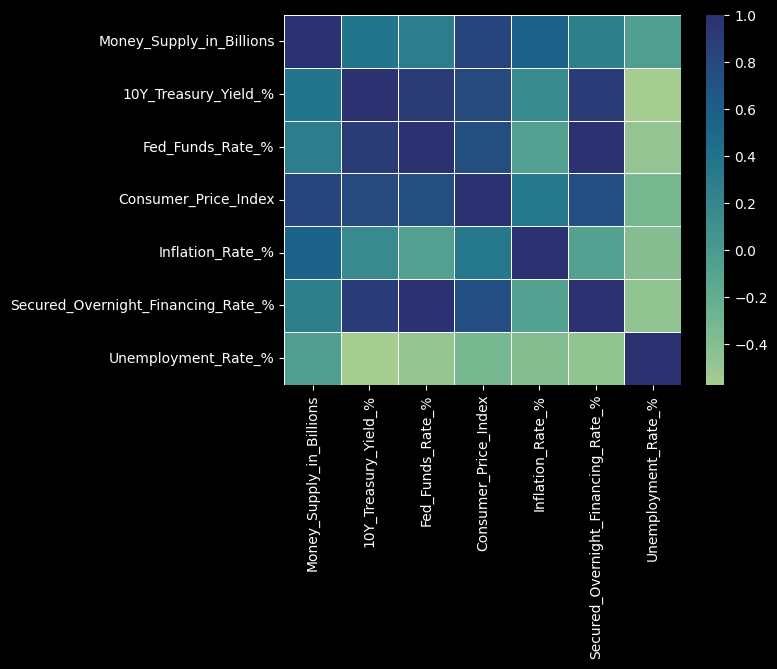

In [ ]:
# Create a Seaborn heatmap of the correlations, passing a custom linewidth and color map and save it to an axis
ax = sns.heatmap(correlations, linewidth=0.5, cmap='crest')

# Show the axis
plt.show()

In [181]:
# Iterate through each column in the DataFrame
for col in econ_data.columns:
    # Calculate a Month over Month change in each column by comparing it's current value to it's previous and save this back to DataFrame using
    # the previous column name with '_MoM_Change' appended to the column name
    econ_data.insert(econ_data.columns.get_loc(col) + 1, col + '_MoM_Change',  econ_data[col].diff())
    # Calculate a Year over Year change in each column by comparing it's current value to that of 12 months ago and save this back to DataFrame 
    # using the previous column name with '_YoY_Change' appended to the column name
    econ_data.insert(econ_data.columns.get_loc(col) + 2, col + '_YoY_Change', econ_data[col].diff(periods=12))

In [182]:
# Print Summary Statistics to the console
econ_data.describe()

,Money_Supply_in_Billions,Money_Supply_in_Billions_MoM_Change,Money_Supply_in_Billions_YoY_Change,10Y_Treasury_Yield_%,10Y_Treasury_Yield_%_MoM_Change,10Y_Treasury_Yield_%_YoY_Change,Fed_Funds_Rate_%,Fed_Funds_Rate_%_MoM_Change,Fed_Funds_Rate_%_YoY_Change,Consumer_Price_Index,Consumer_Price_Index_MoM_Change,Consumer_Price_Index_YoY_Change,Inflation_Rate_%,Inflation_Rate_%_MoM_Change,Inflation_Rate_%_YoY_Change,Secured_Overnight_Financing_Rate_%,Secured_Overnight_Financing_Rate_%_MoM_Change,Secured_Overnight_Financing_Rate_%_YoY_Change,Unemployment_Rate_%,Unemployment_Rate_%_MoM_Change,Unemployment_Rate_%_YoY_Change
count,87.000000,86.000000,75.000000,87.000000,86.000000,75.000000,87.000000,86.000000,75.000000,87.000000,86.000000,75.000000,87.000000,86.000000,75.000000,87.000000,86.000000,75.000000,87.000000,86.000000,75.000000
mean,19039.759770,92.419767,1163.617333,2.762069,0.018023,0.220933,2.496552,0.030698,0.411600,282.105977,0.818023,10.489867,3.586092,-0.001047,0.053733,2.477816,0.029651,0.412133,4.605747,0.001163,0.046667
std,2877.710376,171.256515,1425.722115,1.271937,0.220709,1.068029,2.012180,0.214096,1.836591,24.990266,0.841472,6.385407,2.272748,0.433047,2.926533,2.027723,0.249807,1.864062,2.017963,1.203670,3.004291
min,13993.900000,-308.500000,-1019.900000,0.620000,-0.630000,-1.870000,0.050000,-0.930000,-2.370000,250.230000,-2.050000,0.500000,0.200000,-1.180000,-5.940000,0.010000,-1.180000,-2.450000,3.400000,-2.200000,-8.700000
25%,15441.900000,18.125000,242.050000,1.625000,-0.100000,-0.765000,0.100000,0.000000,-0.850000,257.515000,0.290000,5.145000,2.000000,-0.207500,-1.240000,0.090000,-0.007500,-0.835000,3.600000,-0.100000,-0.750000
50%,20720.600000,68.600000,805.000000,2.890000,0.005000,0.530000,2.200000,0.000000,0.010000,278.820000,0.720000,9.300000,2.810000,0.010000,-0.650000,2.220000,0.000000,0.000000,3.900000,0.000000,0.000000
75%,21294.700000,132.375000,2335.950000,3.940000,0.150000,0.840000,4.525000,0.040000,1.065000,306.755000,1.227500,14.055000,4.940000,0.267500,1.330000,4.550000,0.030000,0.900000,4.200000,0.100000,0.400000
max,21942.000000,1012.000000,4129.700000,4.800000,0.620000,2.400000,5.330000,0.700000,4.500000,320.580000,3.770000,24.360000,9.000000,1.520000,6.280000,5.340000,0.760000,4.510000,14.800000,10.400000,11.100000


In [183]:
# Create a blank DataFrame to store all of the original raw values
raw_df = pd.DataFrame()

# Create a blank DataFrame to store all of the MoM change values
mon_change_df = pd.DataFrame()

# Create a blank DataFraem to store all of the YoY change values
yr_change_df = pd.DataFrame()

# Iterate through all of the column names in what I'll now call the 'Master' DataFrame
for col in econ_data.columns:
    # If the column name associated with this iteration contains '_MoM'
    if '_MoM' in col:
        # Append the column to the mon_change_df DataFrame
        mon_change_df[col] = econ_data[col]
    # If the column name associated with this iteration contains '_YoY'
    elif '_YoY' in col:
        # Append the column to the yr_change_df DataFrame
        yr_change_df[col] = econ_data[col]
    # If the column name contains neither pattern
    else:
        # Append the column to the DataFrame designed to store the original raw values
        raw_df[col] = econ_data[col]

# Drop the 1st row of mon_change_df as at this point there was no previous value to compare to, and all values are NaN
mon_change_df = mon_change_df[1:]

# Drop the 1st 12 rows of yr_change_df as at this point there was no previous value to compare to, and all values are NaN
yr_change_df = yr_change_df[12:]

# Sanity check
raw_df

Money_Supply_in_Billions  10Y_Treasury_Yield_%  \
Year Month                                                      
2018 April                      13993.9                  2.87   
     May                        14049.6                  2.98   
     June                       14109.9                  2.91   
     July                       14144.2                  2.89   
     August                     14193.9                  2.89   
...                                 ...                   ...   
2025 February                   21613.5                  4.45   
     March                      21706.4                  4.28   
     April                      21862.4                  4.28   
     May                        21942.0                  4.42   
     June                       21942.0                  4.42   

               Fed_Funds_Rate_%  Consumer_Price_Index  Inflation_Rate_%  \
Year Month                                                                
2018 April                 1.69                250.23              2.47   
     May                   1.70                250.79              2.78   
     June                  1.82                251.02              2.81   
     July                  1.91                251.21              2.85   
     August                1.91                251.66              2.64   
...                         ...                   ...               ...   
2025 February              4.33                319.77              2.81   
     March                 4.33                319.62              2.41   
     April                 4.33                320.32              2.33   
     May                   4.33                320.58              2.38   
     June                  4.33                320.58              2.38   

               Secured_Overnight_Financing_Rate_%  Unemployment_Rate_%  
Year Month                                                              
2018 April                                   1.74                  4.0  
     May                                     1.73                  3.8  
     June                                    1.87                  4.0  
     July                                    1.90                  3.8  
     August                                  1.91                  3.8  
...                                           ...                  ...  
2025 February                                4.34                  4.1  
     March                                   4.33                  4.2  
     April                                   4.35                  4.2  
     May                                     4.30                  4.2  
     June                                    4.29                  4.1  

[87 rows x 7 columns]